In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/chandniagarwal/Gan_Classifier.git

In [3]:
import sys
sys.path.append('/content/Gan_Classifier/src')
import glob
import os
import numpy as np
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import optimizers


from keras.models import Sequential
from keras.layers import Input, Dense, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import time
import random
import seaborn as sns
from DatasetCreation import DatasetCreation
from Model import Model
from ElmModel import elm
from numba import cuda

In [4]:
tf.random.set_seed(
    42
)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
list_images=[]
labels=[]

In [5]:
# Testing Data Location
test_gt = "/content/drive/MyDrive/imageclassificationmodel/Datasets_FR/Testing/images_classification/gt"
test_gen = "/content/drive/MyDrive/imageclassificationmodel/Datasets_FR/Testing/images_classification/gen"
test_ec = "/content/drive/MyDrive/imageclassificationmodel/Datasets_FR/Testing/images_classification/ec"
test_vqvae = "/content/drive/MyDrive/imageclassificationmodel/Datasets_FR/Testing/images_classification/vqvae"
test_mask = "/content/drive/MyDrive/imageclassificationmodel/dataset/mask2000"
test_unmask = "/content/drive/MyDrive/imageclassificationmodel/dataset/gt2000"


In [6]:
# test_gt = '/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/e3'
# test_vqvae='/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/g3'

In [7]:
# Training Data Location
train_gt='/content/drive/MyDrive/imageclassificationmodel/Datasets_FR/training/gt'
train_recon='/content/drive/MyDrive/imageclassificationmodel/Datasets_FR/training/gen'

In [8]:
# training Data
image_loc_ground = glob.glob(train_gt+"/*.jpg")
labels = len(image_loc_ground) * ["ground"]
image_loc_recon = glob.glob(train_recon+"/*.jpg")

# so reconstructed and ground image dataset is of same size
random.shuffle(image_loc_recon)
image_loc_recon = image_loc_recon[:len(image_loc_ground)]

labels += len(image_loc_recon) * ["recon"]
image_loc = image_loc_ground + image_loc_recon
training_dataset = DatasetCreation(image_loc, labels, "bina ry")
# for 152 layer
training_dataset_152_layer = DatasetCreation(
    image_loc, labels, "binary", tf.keras.applications.resnet50.preprocess_input
)
print(training_dataset.images.shape)
print(training_dataset.labels.shape)

_________Loading Images__________


100%|██████████| 5476/5476 [21:03<00:00,  4.33it/s]


_________Loading Images__________


100%|██████████| 5476/5476 [00:20<00:00, 266.61it/s]


(5476, 224, 224, 3)
(5476,)


## load model

In [9]:
def load_model(model_function, trainable:bool):
  start = time.time()
  # load resnet model
  base_model = model_function(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet'
  )

  for layer in base_model.layers:
      layer.trainable = trainable

  # Create your binary classification layers on top of the base model
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = tf.keras.layers.Dense(1000, activation='relu')(x) # intermediate hidden layer
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary classification output layer

  # Combine the base model and your custom layers into a new model
  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  print('Running time: %.4f seconds' % (time.time()-start))
  return model

In [10]:
model_resnet_152_full = load_model(tf.keras.applications.ResNet152, True)
model_resnet_101_full = load_model(tf.keras.applications.ResNet101, True)
model_resnet_50_full = load_model(tf.keras.applications.ResNet50, True)

model_resnet_152_freeze = load_model(tf.keras.applications.ResNet152, False)
model_resnet_101_freeze = load_model(tf.keras.applications.ResNet101, False)
model_resnet_50_freeze = load_model(tf.keras.applications.ResNet50, False)

Running time: 6.3363 seconds
Running time: 3.0841 seconds
Running time: 1.6380 seconds
Running time: 4.8264 seconds
Running time: 3.2284 seconds
Running time: 1.7186 seconds


In [12]:
model_softmax = {
    "50_full": model_resnet_50_full,
    "50_freeze": model_resnet_50_freeze,
    "101_full": model_resnet_101_full,
    "101_freeze": model_resnet_101_freeze,
    "152_full": model_resnet_152_full,
    "152_freeze": model_resnet_152_freeze,
}
model_data = {
    "152_freeze": training_dataset_152_layer,
    "152_full": training_dataset_152_layer,
    "101_freeze": training_dataset,
    "101_full": training_dataset,
    "50_freeze": training_dataset,
    "50_full": training_dataset
}

## Resnet Training

In [13]:
for key in model_softmax.keys():
  print("_"*10, key, "_"*50)
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint_sigmoid/{key}', "binary_crossentropy")
  model_softmax[key].train(model_data[key].images, model_data[key].labels, batch_size=32, epoch=10)
  tf.keras.backend.clear_session()

__________ 50_full __________________________________________________
Epoch 1/10
154/154 [==============================] - 97s 324ms/step - loss: 0.2820 - accuracy: 0.9054 - val_loss: 0.2358 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
154/154 [==============================] - 48s 309ms/step - loss: 0.0602 - accuracy: 0.9797 - val_loss: 0.4369 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
154/154 [==============================] - 48s 314ms/step - loss: 0.0349 - accuracy: 0.9870 - val_loss: 1.4547 - val_accuracy: 0.3540 - lr: 0.0010
Epoch 4/10
154/154 [==============================] - 49s 318ms/step - loss: 0.0105 - accuracy: 0.9970 - val_loss: 0.0111 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 5/10
154/154 [==============================] - 48s 314ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 1.3222 - val_accuracy: 0.6569 - lr: 5.0000e-04
Epoch 6/10
154/154 [==============================] - 49s 318ms/step - loss: 0.0135 - accuracy: 0.9955 - val_loss: 0.0033 - val_accu

## Elm Training

In [14]:
for key in model_softmax.keys():
  for layer in model_softmax[key].model.layers:
      layer.trainable = False
  model_softmax[key].remove_layer(2)

In [15]:
def batch_predict(model, images, batch=32):
  array1 = []
  for idx in range(0, len(images), batch):
    array2 = model.predict(images[idx: min(len(images), idx+batch)], verbose=0)
    if len(array1)>0:
      array1 = np.concatenate((array1, array2), axis=0)
    else:
      array1 = array2
  return array1

In [16]:
model_elm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 8)
  Ytrain = model_data[key].labels

  model_elm[key] = elm(hidden_units=16, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
  beta, train_accuracy, running_time = model_elm[key].fit('solution2')
  print("classifier train accuracy:", train_accuracy)
  print('classifier running time:', running_time)

__________ 50_full __________
classifier train accuracy: 0.993791088385683
classifier running time: 0.04007244110107422
__________ 50_freeze __________
classifier train accuracy: 0.5489408327246165
classifier running time: 0.022182941436767578
__________ 101_full __________
classifier train accuracy: 0.9985390796201608
classifier running time: 0.022971391677856445
__________ 101_freeze __________
classifier train accuracy: 0.5661066471877283
classifier running time: 0.021939992904663086
__________ 152_full __________
classifier train accuracy: 0.99981738495252
classifier running time: 0.02082967758178711
__________ 152_freeze __________
classifier train accuracy: 0.7616873630387144
classifier running time: 0.02129077911376953


## Svm Training

In [17]:
model_svm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  #with tf.device('/CPU:0'):
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 8)
  Ytrain = model_data[key].labels
  model_svm[key] = make_pipeline(SVC())
  model_svm[key].fit(Xtrain, Ytrain)
  print("Classifier train accuracy:", model_svm[key].score(Xtrain, Ytrain))

__________ 50_full __________
Classifier train accuracy: 0.9943389335281227
__________ 50_freeze __________
Classifier train accuracy: 0.6163257852447042
__________ 101_full __________
Classifier train accuracy: 0.99981738495252
__________ 101_freeze __________
Classifier train accuracy: 0.633308984660336
__________ 152_full __________
Classifier train accuracy: 0.99981738495252
__________ 152_freeze __________
Classifier train accuracy: 0.839481373265157


In [18]:
#dump training data
training_dataset = None
training_dataset_152_layer = None
model_data = None

## Load Test Data

In [19]:
# test Data
image_loc_ground = glob.glob(test_gt+"/*.jpg")
label_ground = len(image_loc_ground) * ["ground"]

image_loc_gen = glob.glob(test_gen+"/*.jpg")
label_gen = len(image_loc_gen) * ["recon"]

image_loc_ec = glob.glob(test_ec+"/*.jpg")
label_ec = len(image_loc_ec) * ["recon"]

image_loc_vqvae = glob.glob(test_vqvae+"/*.jpg")
label_vqvae = len(image_loc_vqvae) * ["recon"]

test_dataset = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary"
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary"
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary"
        ),
}

test_dataset_152_layer = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
}
model_data = {
    "152_full": test_dataset_152_layer,
    "101_full": test_dataset,
    "50_full": test_dataset,
    "152_freeze": test_dataset_152_layer,
    "101_freeze": test_dataset,
    "50_freeze": test_dataset,
}

_________Loading Images__________


100%|██████████| 2000/2000 [10:48<00:00,  3.09it/s]


_________Loading Images__________


100%|██████████| 2000/2000 [10:34<00:00,  3.15it/s]


_________Loading Images__________


100%|██████████| 2000/2000 [10:29<00:00,  3.18it/s]


_________Loading Images__________


100%|██████████| 2000/2000 [00:07<00:00, 282.33it/s]


_________Loading Images__________


100%|██████████| 2000/2000 [00:06<00:00, 290.81it/s]


_________Loading Images__________


100%|██████████| 2000/2000 [00:07<00:00, 274.30it/s]


## Testing Resnet

In [20]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    y_result = batch_predict(model_softmax[model_name].model, model_data[model_name][key].images, 8)
    y_result = y_result>0.5

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

__________ 50_full __________
__________gen__________
Accuracy 0.9825
Precision: 0.999000
Recall: 0.967086
F1 score: 0.982784
__________ec__________
Accuracy 0.949
Precision: 0.932000
Recall: 0.964803
F1 score: 0.948118
__________vqvae__________
Accuracy 0.645
Precision: 0.324000
Recall: 0.905028
F1 score: 0.477172
__________ 50_freeze __________
__________gen__________
Accuracy 0.5585
Precision: 0.715000
Recall: 0.544554
F1 score: 0.618245
__________ec__________
Accuracy 0.63
Precision: 0.858000
Recall: 0.589286
F1 score: 0.698697
__________vqvae__________
Accuracy 0.5035
Precision: 0.605000
Recall: 0.502909
F1 score: 0.549251
__________ 101_full __________
__________gen__________
Accuracy 0.9935
Precision: 0.994000
Recall: 0.993007
F1 score: 0.993503
__________ec__________
Accuracy 0.8335
Precision: 0.674000
Recall: 0.989721
F1 score: 0.801904
__________vqvae__________
Accuracy 0.552
Precision: 0.111000
Recall: 0.940678
F1 score: 0.198569
__________ 101_freeze __________
__________ge

## Testing ELM

__________ 50_full __________
__________gen__________
Accuracy 0.9885
Precision: 0.996000
Recall: 0.981281
F1 score: 0.988586


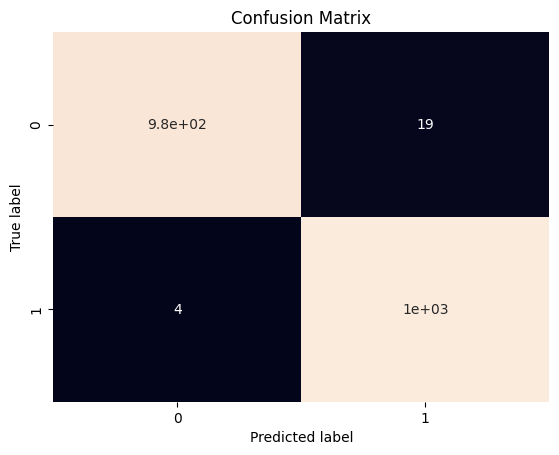

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1000
           1       0.98      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

__________ec__________
Accuracy 0.9275
Precision: 0.874000
Recall: 0.978723
F1 score: 0.923402


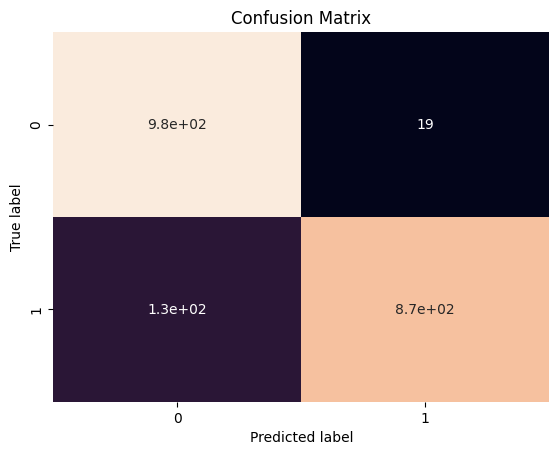

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1000
           1       0.98      0.87      0.92      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

__________vqvae__________
Accuracy 0.571
Precision: 0.161000
Recall: 0.894444
F1 score: 0.272881


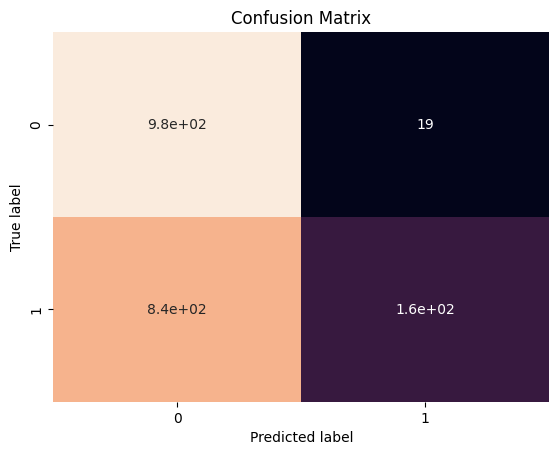

              precision    recall  f1-score   support

           0       0.54      0.98      0.70      1000
           1       0.89      0.16      0.27      1000

    accuracy                           0.57      2000
   macro avg       0.72      0.57      0.48      2000
weighted avg       0.72      0.57      0.48      2000

__________ 50_freeze __________
__________gen__________
Accuracy 0.5455
Precision: 0.574000
Recall: 0.543046
F1 score: 0.558094


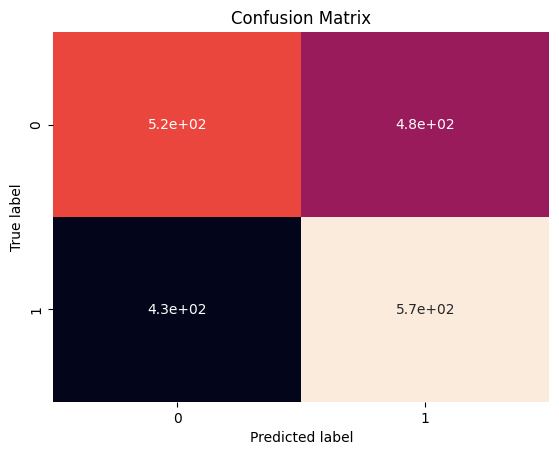

              precision    recall  f1-score   support

           0       0.55      0.52      0.53      1000
           1       0.54      0.57      0.56      1000

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.55      0.55      0.55      2000

__________ec__________
Accuracy 0.607
Precision: 0.697000
Recall: 0.590678
F1 score: 0.639450


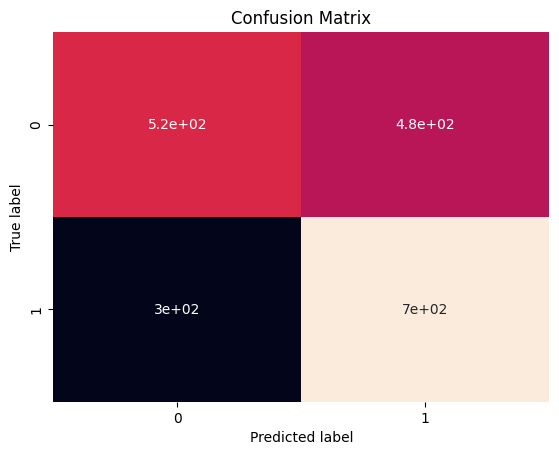

              precision    recall  f1-score   support

           0       0.63      0.52      0.57      1000
           1       0.59      0.70      0.64      1000

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.60      2000
weighted avg       0.61      0.61      0.60      2000

__________vqvae__________
Accuracy 0.4855
Precision: 0.454000
Recall: 0.484525
F1 score: 0.468766


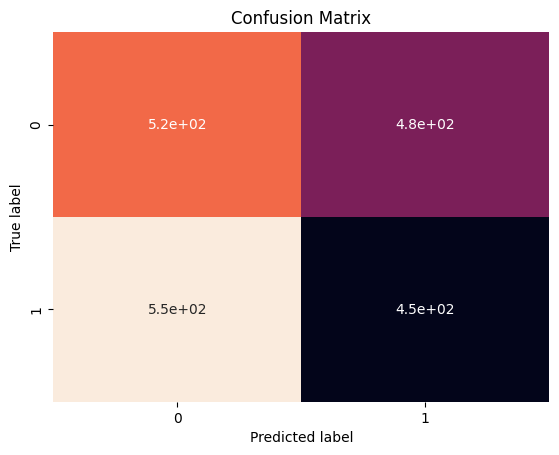

              precision    recall  f1-score   support

           0       0.49      0.52      0.50      1000
           1       0.48      0.45      0.47      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.48      2000
weighted avg       0.49      0.49      0.48      2000

__________ 101_full __________
__________gen__________
Accuracy 0.993
Precision: 0.994000
Recall: 0.992016
F1 score: 0.993007


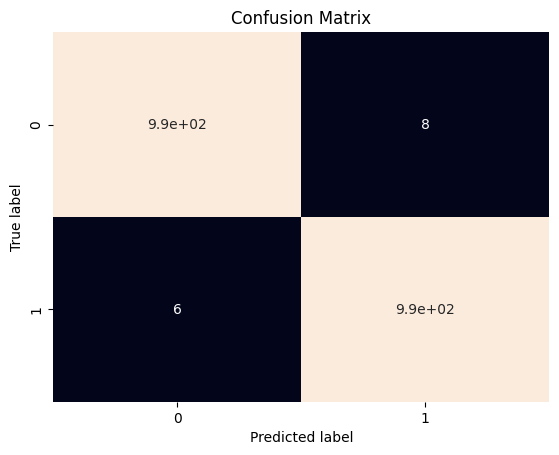

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

__________ec__________
Accuracy 0.885
Precision: 0.778000
Recall: 0.989822
F1 score: 0.871221


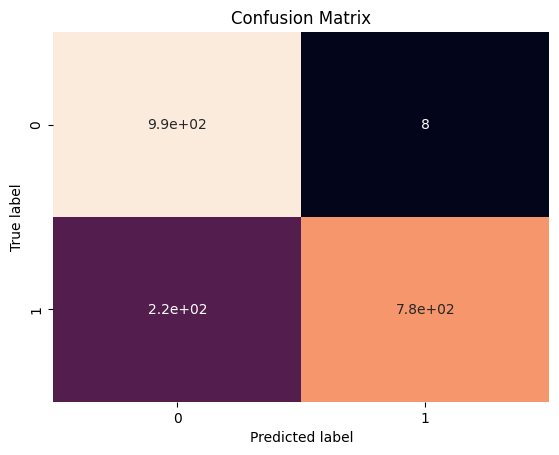

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1000
           1       0.99      0.78      0.87      1000

    accuracy                           0.89      2000
   macro avg       0.90      0.89      0.88      2000
weighted avg       0.90      0.89      0.88      2000

__________vqvae__________
Accuracy 0.586
Precision: 0.180000
Recall: 0.957447
F1 score: 0.303030


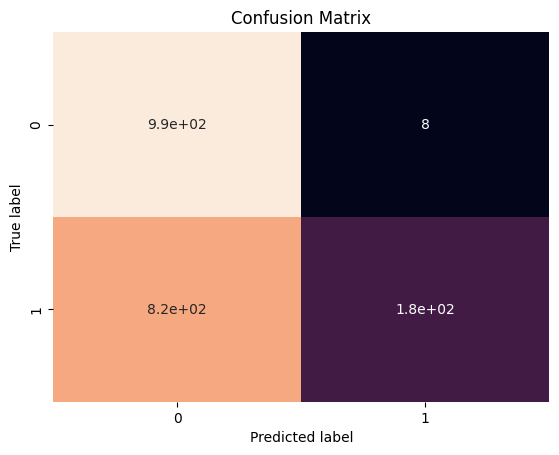

              precision    recall  f1-score   support

           0       0.55      0.99      0.71      1000
           1       0.96      0.18      0.30      1000

    accuracy                           0.59      2000
   macro avg       0.75      0.59      0.50      2000
weighted avg       0.75      0.59      0.50      2000

__________ 101_freeze __________
__________gen__________
Accuracy 0.553
Precision: 0.601000
Recall: 0.548358
F1 score: 0.573473


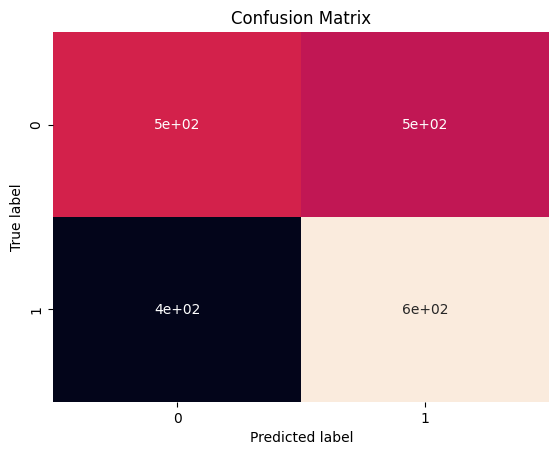

              precision    recall  f1-score   support

           0       0.56      0.51      0.53      1000
           1       0.55      0.60      0.57      1000

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.55      0.55      0.55      2000

__________ec__________
Accuracy 0.577
Precision: 0.649000
Recall: 0.567308
F1 score: 0.605410


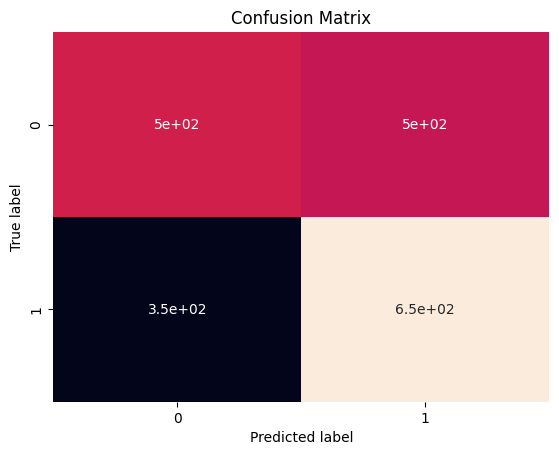

              precision    recall  f1-score   support

           0       0.59      0.51      0.54      1000
           1       0.57      0.65      0.61      1000

    accuracy                           0.58      2000
   macro avg       0.58      0.58      0.57      2000
weighted avg       0.58      0.58      0.57      2000

__________vqvae__________
Accuracy 0.483
Precision: 0.461000
Recall: 0.482218
F1 score: 0.471370


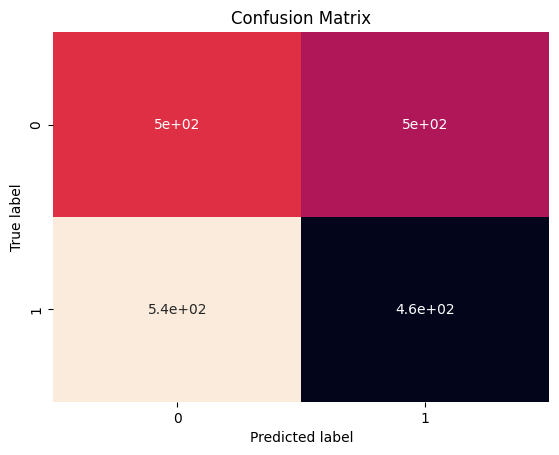

              precision    recall  f1-score   support

           0       0.48      0.51      0.49      1000
           1       0.48      0.46      0.47      1000

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.48      0.48      0.48      2000

__________ 152_full __________
__________gen__________
Accuracy 0.996
Precision: 0.998000
Recall: 0.994024
F1 score: 0.996008


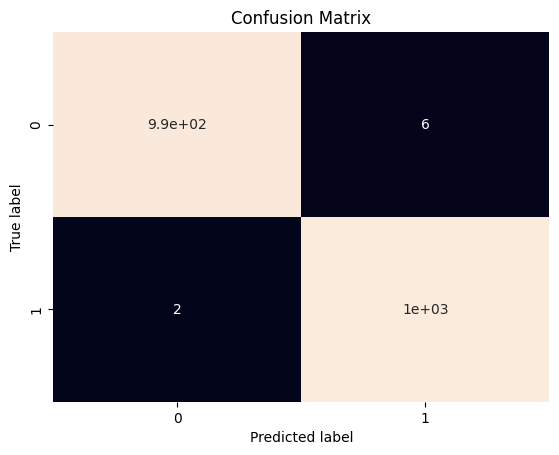

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1000
           1       0.99      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

__________ec__________
Accuracy 0.7475
Precision: 0.501000
Recall: 0.988166
F1 score: 0.664897


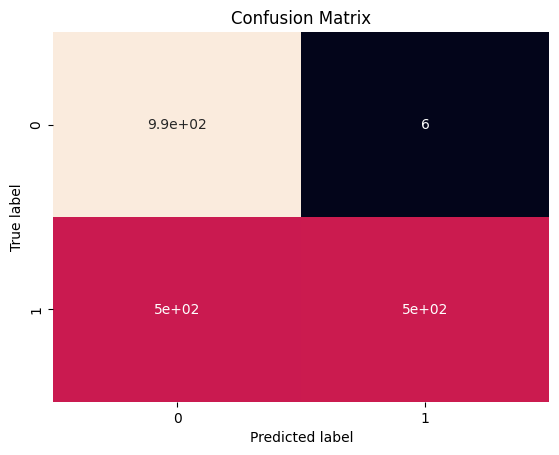

              precision    recall  f1-score   support

           0       0.67      0.99      0.80      1000
           1       0.99      0.50      0.66      1000

    accuracy                           0.75      2000
   macro avg       0.83      0.75      0.73      2000
weighted avg       0.83      0.75      0.73      2000

__________vqvae__________
Accuracy 0.52
Precision: 0.046000
Recall: 0.884615
F1 score: 0.087452


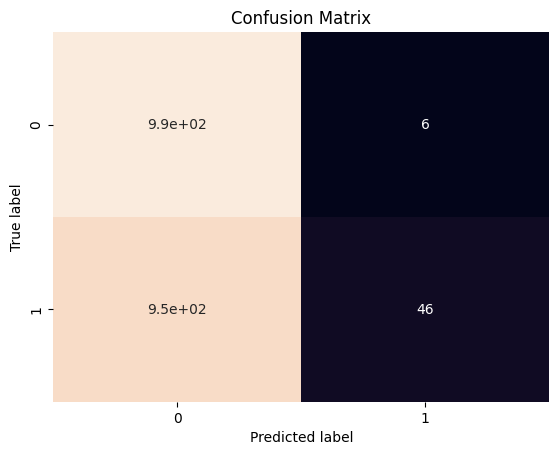

              precision    recall  f1-score   support

           0       0.51      0.99      0.67      1000
           1       0.88      0.05      0.09      1000

    accuracy                           0.52      2000
   macro avg       0.70      0.52      0.38      2000
weighted avg       0.70      0.52      0.38      2000

__________ 152_freeze __________
__________gen__________
Accuracy 0.7435
Precision: 0.694000
Recall: 0.770255
F1 score: 0.730142


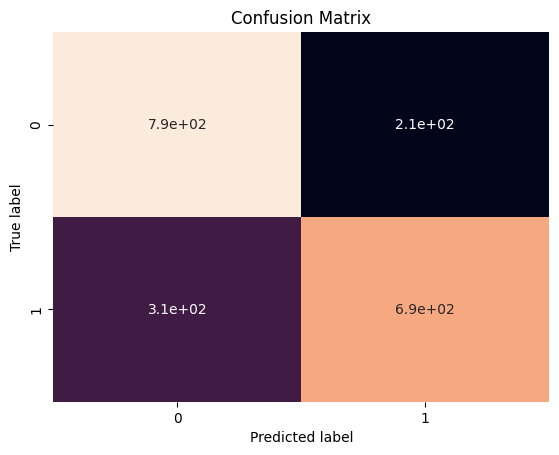

              precision    recall  f1-score   support

           0       0.72      0.79      0.76      1000
           1       0.77      0.69      0.73      1000

    accuracy                           0.74      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.75      0.74      0.74      2000

__________ec__________
Accuracy 0.8675
Precision: 0.942000
Recall: 0.819843
F1 score: 0.876687


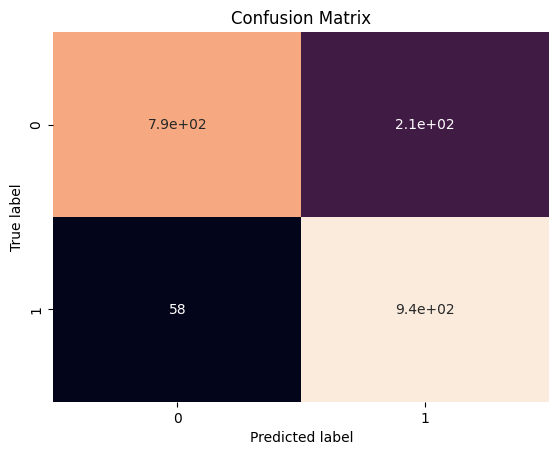

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1000
           1       0.82      0.94      0.88      1000

    accuracy                           0.87      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.88      0.87      0.87      2000

__________vqvae__________
Accuracy 0.6995
Precision: 0.606000
Recall: 0.745387
F1 score: 0.668505


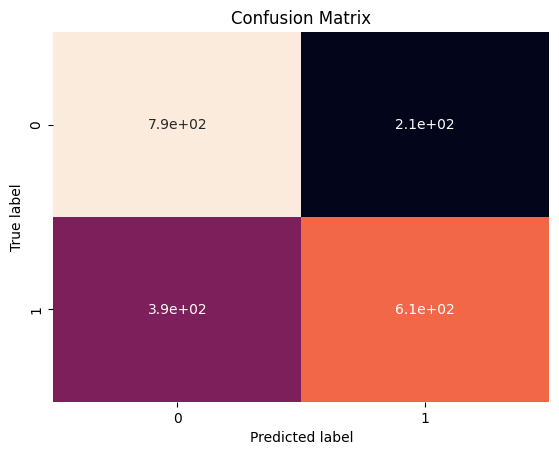

              precision    recall  f1-score   support

           0       0.67      0.79      0.73      1000
           1       0.75      0.61      0.67      1000

    accuracy                           0.70      2000
   macro avg       0.71      0.70      0.70      2000
weighted avg       0.71      0.70      0.70      2000


In [21]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 8)
    y_result = model_elm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(labels, y_result))

## Testing SVM

__________ 50_full __________
__________gen__________
Accuracy 0.9885
Precision: 0.991000
Recall: 0.986070
F1 score: 0.988529


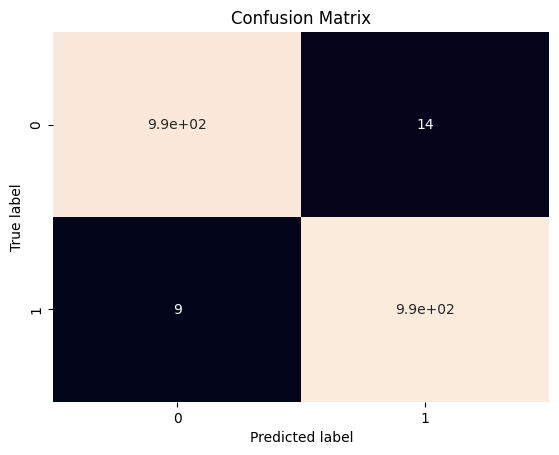

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

__________ec__________
Accuracy 0.913
Precision: 0.840000
Recall: 0.983607
F1 score: 0.906149


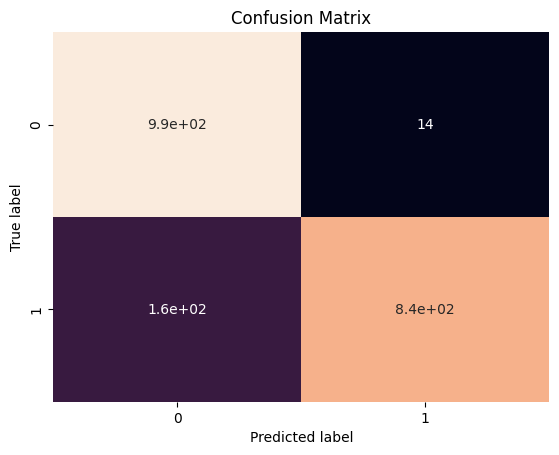

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1000
           1       0.98      0.84      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.91      0.91      2000

__________vqvae__________
Accuracy 0.5595
Precision: 0.133000
Recall: 0.904762
F1 score: 0.231909


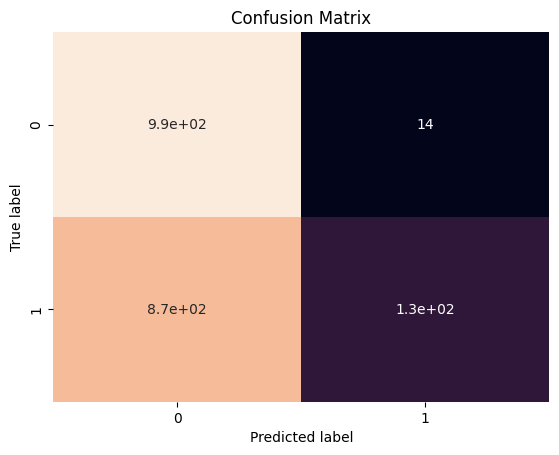

              precision    recall  f1-score   support

           0       0.53      0.99      0.69      1000
           1       0.90      0.13      0.23      1000

    accuracy                           0.56      2000
   macro avg       0.72      0.56      0.46      2000
weighted avg       0.72      0.56      0.46      2000

__________ 50_freeze __________
__________gen__________
Accuracy 0.5775
Precision: 0.612000
Recall: 0.572498
F1 score: 0.591590


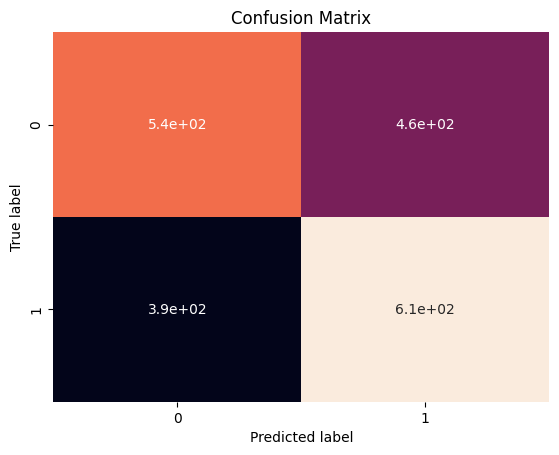

              precision    recall  f1-score   support

           0       0.58      0.54      0.56      1000
           1       0.57      0.61      0.59      1000

    accuracy                           0.58      2000
   macro avg       0.58      0.58      0.58      2000
weighted avg       0.58      0.58      0.58      2000

__________ec__________
Accuracy 0.6335
Precision: 0.724000
Recall: 0.613040
F1 score: 0.663916


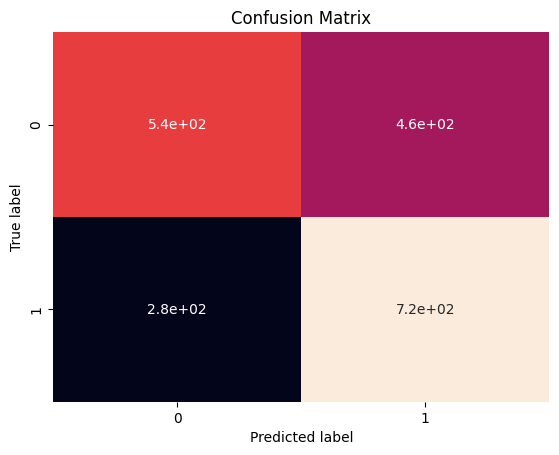

              precision    recall  f1-score   support

           0       0.66      0.54      0.60      1000
           1       0.61      0.72      0.66      1000

    accuracy                           0.63      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.63      0.63      2000

__________vqvae__________
Accuracy 0.4915
Precision: 0.440000
Recall: 0.490524
F1 score: 0.463890


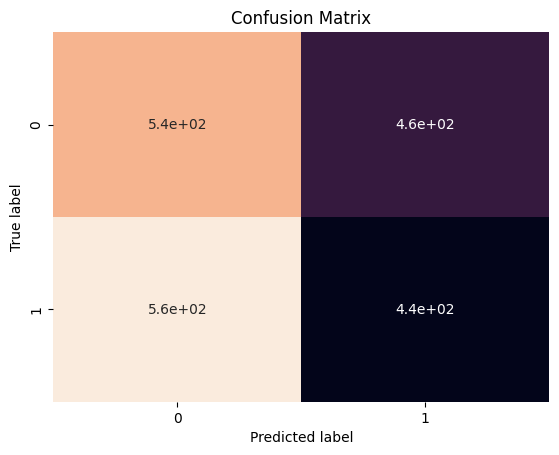

              precision    recall  f1-score   support

           0       0.49      0.54      0.52      1000
           1       0.49      0.44      0.46      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000

__________ 101_full __________
__________gen__________
Accuracy 0.9935
Precision: 0.994000
Recall: 0.993007
F1 score: 0.993503


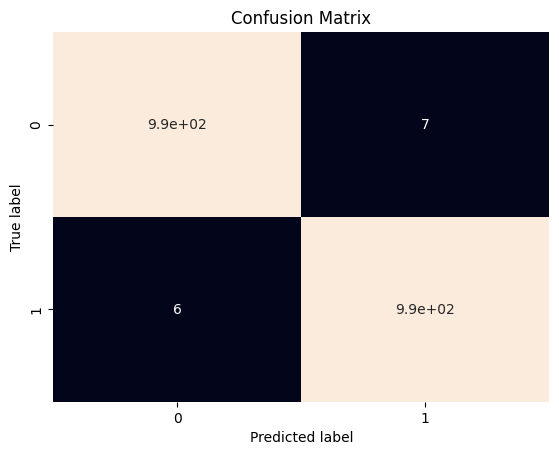

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

__________ec__________
Accuracy 0.8345
Precision: 0.676000
Recall: 0.989751
F1 score: 0.803327


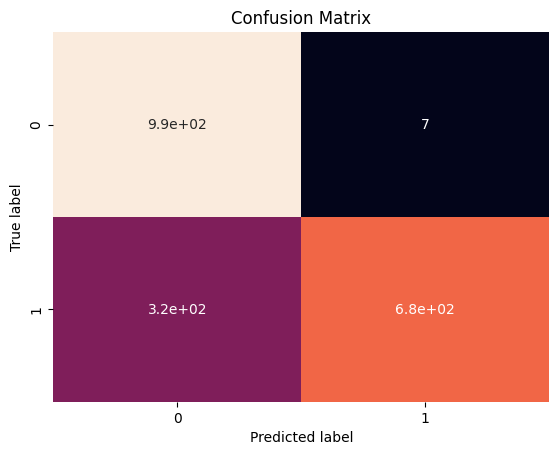

              precision    recall  f1-score   support

           0       0.75      0.99      0.86      1000
           1       0.99      0.68      0.80      1000

    accuracy                           0.83      2000
   macro avg       0.87      0.83      0.83      2000
weighted avg       0.87      0.83      0.83      2000

__________vqvae__________
Accuracy 0.553
Precision: 0.113000
Recall: 0.941667
F1 score: 0.201786


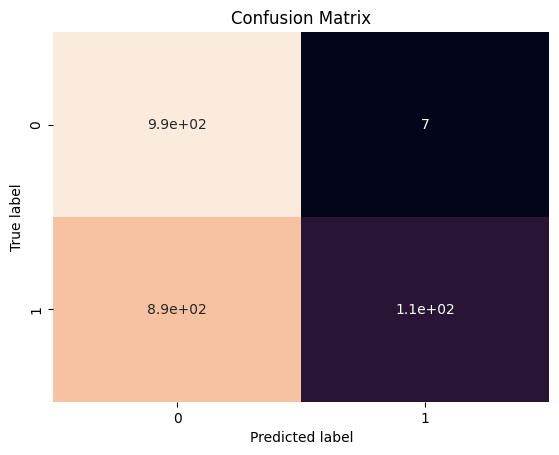

              precision    recall  f1-score   support

           0       0.53      0.99      0.69      1000
           1       0.94      0.11      0.20      1000

    accuracy                           0.55      2000
   macro avg       0.73      0.55      0.45      2000
weighted avg       0.73      0.55      0.45      2000

__________ 101_freeze __________
__________gen__________
Accuracy 0.5715
Precision: 0.604000
Recall: 0.567136
F1 score: 0.584988


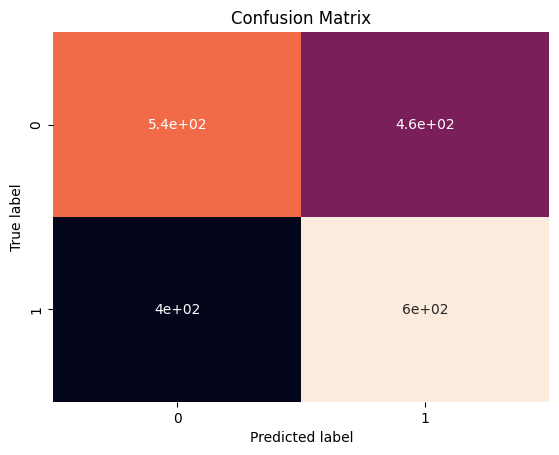

              precision    recall  f1-score   support

           0       0.58      0.54      0.56      1000
           1       0.57      0.60      0.58      1000

    accuracy                           0.57      2000
   macro avg       0.57      0.57      0.57      2000
weighted avg       0.57      0.57      0.57      2000

__________ec__________
Accuracy 0.601
Precision: 0.663000
Recall: 0.589858
F1 score: 0.624294


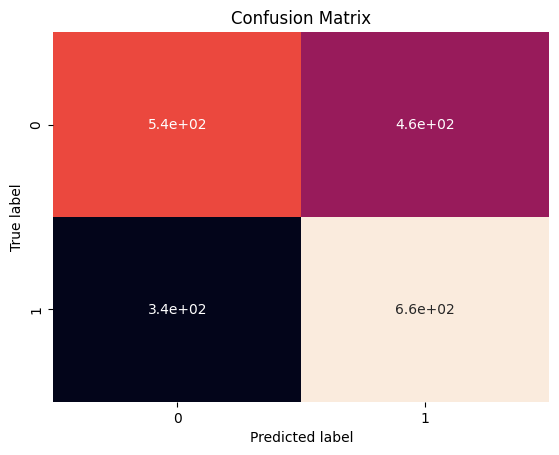

              precision    recall  f1-score   support

           0       0.62      0.54      0.57      1000
           1       0.59      0.66      0.62      1000

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000

__________vqvae__________
Accuracy 0.4765
Precision: 0.414000
Recall: 0.473143
F1 score: 0.441600


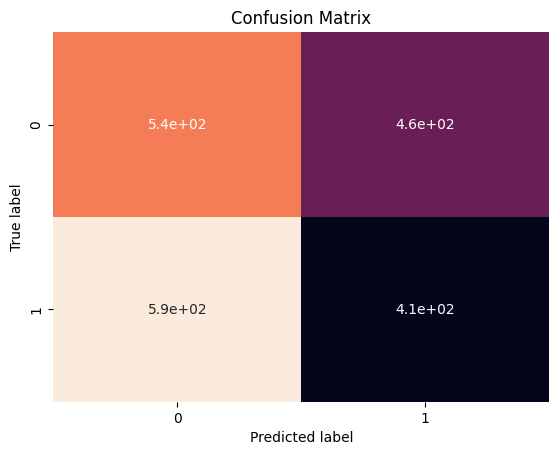

              precision    recall  f1-score   support

           0       0.48      0.54      0.51      1000
           1       0.47      0.41      0.44      1000

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.47      2000
weighted avg       0.48      0.48      0.47      2000

__________ 152_full __________
__________gen__________
Accuracy 0.994
Precision: 0.999000
Recall: 0.989109
F1 score: 0.994030


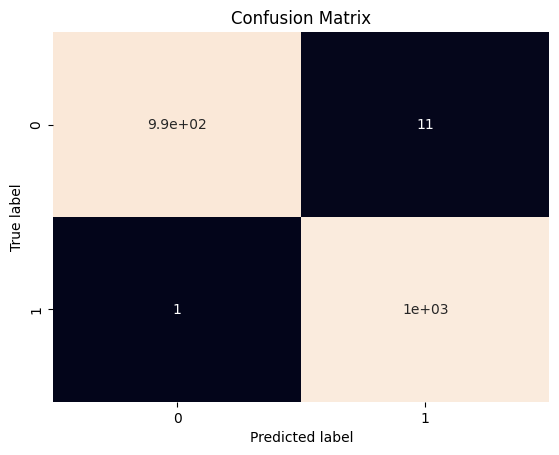

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1000
           1       0.99      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

__________ec__________
Accuracy 0.7665
Precision: 0.544000
Recall: 0.980180
F1 score: 0.699678


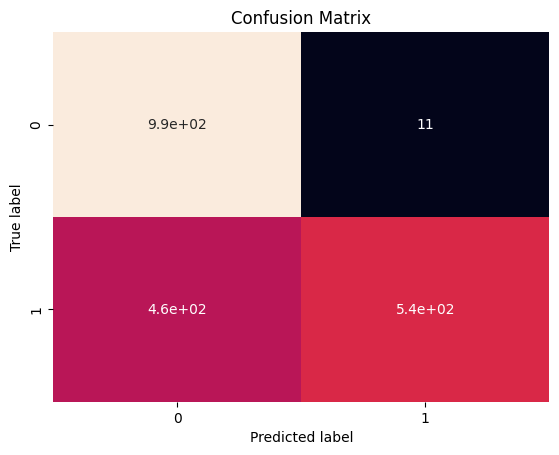

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      1000
           1       0.98      0.54      0.70      1000

    accuracy                           0.77      2000
   macro avg       0.83      0.77      0.75      2000
weighted avg       0.83      0.77      0.75      2000

__________vqvae__________
Accuracy 0.527
Precision: 0.065000
Recall: 0.855263
F1 score: 0.120818


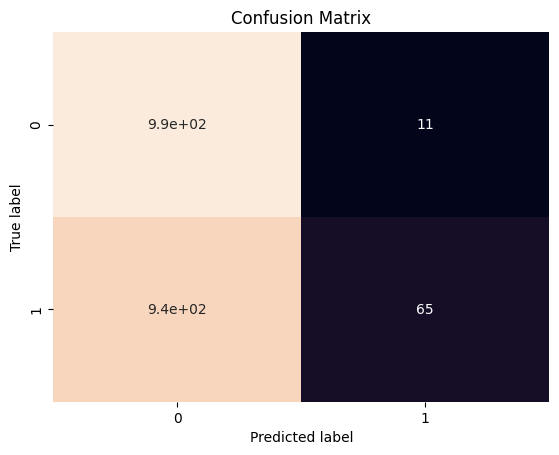

              precision    recall  f1-score   support

           0       0.51      0.99      0.68      1000
           1       0.86      0.07      0.12      1000

    accuracy                           0.53      2000
   macro avg       0.68      0.53      0.40      2000
weighted avg       0.68      0.53      0.40      2000

__________ 152_freeze __________
__________gen__________
Accuracy 0.7925
Precision: 0.728000
Recall: 0.835821
F1 score: 0.778193


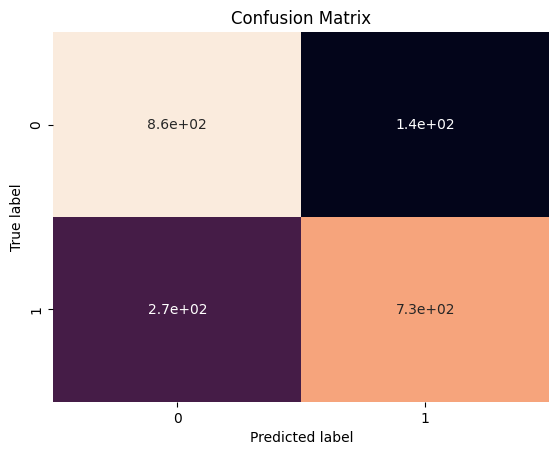

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      1000
           1       0.84      0.73      0.78      1000

    accuracy                           0.79      2000
   macro avg       0.80      0.79      0.79      2000
weighted avg       0.80      0.79      0.79      2000

__________ec__________
Accuracy 0.9165
Precision: 0.976000
Recall: 0.872207
F1 score: 0.921189


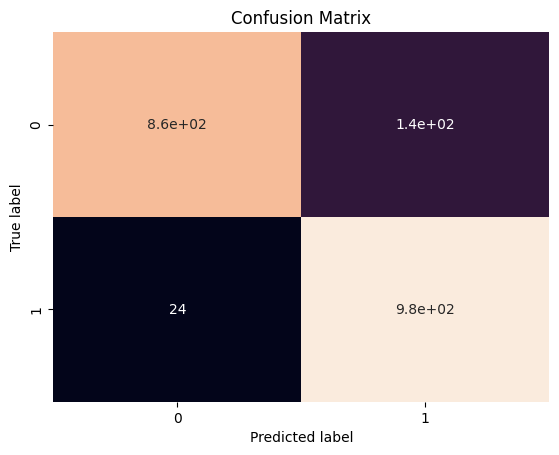

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1000
           1       0.87      0.98      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

__________vqvae__________
Accuracy 0.7265
Precision: 0.596000
Recall: 0.806495
F1 score: 0.685451


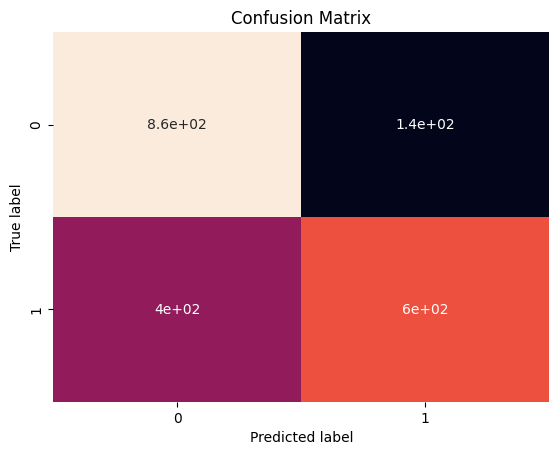

              precision    recall  f1-score   support

           0       0.68      0.86      0.76      1000
           1       0.81      0.60      0.69      1000

    accuracy                           0.73      2000
   macro avg       0.74      0.73      0.72      2000
weighted avg       0.74      0.73      0.72      2000


In [22]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 8)
    y_result = model_svm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(labels, y_result))